In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.9 MB/s eta 0:00:00


In [ ]:
from collections import defaultdict
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import re
import tensorflow as tf
import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
from PIL import ImageFont
import visualkeras
import jieba
# from fugashi import Tagger
# from hanziconv import HanziConv
# from pythainlp.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace


In [ ]:
splits = {'train': 'train.csv', 'validation': 'valid.csv', 'test': 'test.csv'}
dftrain = pd.read_csv("hf://datasets/papluca/language-identification/" + splits["train"], encoding='utf-8')
dfval = pd.read_csv("hf://datasets/papluca/language-identification/" + splits["validation"], encoding='utf-8')
dftest = pd.read_csv("hf://datasets/papluca/language-identification/" + splits["test"], encoding='utf-8')

dftrain['prediction']=None
dfval['prediction']=None
dftest['prediction']=None
print(dftest)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


     labels                                               text prediction
0        nl                    Een man zingt en speelt gitaar.       None
1        nl  De technologisch geplaatste Nasdaq Composite I...       None
2        es  Es muy resistente la parte trasera rígida y lo...       None
3        it  "In tanti modi diversi, l'abilità artistica de...       None
4        ar  منحدر يواجه العديد من النقاشات المتجهه إزاء ال...       None
...     ...                                                ...        ...
9995     zh                               史料很充分，对岸的很多观点与大陆迥异啊。       None
9996     tr  Örneğin, teşhis Yunanca bir kelimeden alındı (...       None
9997     vi  Nếu lite/light chỉ đơn giản là mô tả một đặc t...       None
9998     bg  Например, една щатска столица, която посетихме...       None
9999     pl                   Mam dla ciebie kilka propozycji:       None

[10000 rows x 3 columns]


In [ ]:
#custom multi lang tokeniser to not have to run identify script model before this
def train_custom_tokenizer(texts, vocab_size=30000, min_frequency=2):
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(special_tokens=["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"],
                         vocab_size=vocab_size, min_frequency=min_frequency)

    tokenizer.train_from_iterator(texts, trainer)
    return tokenizer

# concat
all_texts = list(dftrain['text']) + list(dfval['text']) + list(dftest['text'])

# Train
custom_tokenizer = train_custom_tokenizer(all_texts)

def preprocess_text(text, lang='unknown'):

    tokens = custom_tokenizer.encode(text)


    return ' '.join(tokens.tokens)

In [ ]:
dftrain['text'] = dftrain['text'].apply(preprocess_text)
dfval['text'] = dfval['text'].apply(preprocess_text)
dftest['text'] = dftest['text'].apply(preprocess_text)

In [ ]:

max_length = 50
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=custom_tokenizer.get_vocab_size(),
    output_sequence_length=max_length,
    standardize=None
)

# train only
vectorize_layer.adapt(dftrain['text'].values)


trainseq = vectorize_layer(dftrain['text'].values).numpy()
valseq = vectorize_layer(dfval['text'].values).numpy()
testseq = vectorize_layer(dftest['text'].values).numpy()

# encode
label_encoder = LabelEncoder()
label_encoder.fit(dftrain['labels'])  # Fit on training data only
encoded_labels_train = label_encoder.transform(dftrain['labels'])
encoded_labels_val = label_encoder.transform(dfval['labels'])
encoded_labels_test = label_encoder.transform(dftest['labels'])


In [ ]:
from keras import regularizers
model = keras.models.Sequential([
    keras.Input(shape=(max_length,)),
    layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=256,
        embeddings_regularizer=regularizers.L2(1e-4)
    ),
    #2 lstm to capture more advanced patterns
    layers.Bidirectional(layers.LSTM(
        256,
        return_sequences=True,
        kernel_regularizer=regularizers.L2(1e-4),
        recurrent_regularizer=regularizers.L2(1e-4)
    )),
    layers.Bidirectional(layers.LSTM(
        256,
        kernel_regularizer=regularizers.L2(1e-4),
        recurrent_regularizer=regularizers.L2(1e-4)
    )),
    #dropout to avoid co adapt
    layers.Dropout(0.5),
    #gradually reduce complexity
    layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.L2(1e-4)
    ),
    layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.L2(1e-4)
    ),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [ ]:
#visualkeras
color_map = defaultdict(dict)
color_map['Dense']['fill'] = 'orange'
color_map['Embedding']['fill'] = 'blue'
color_map['Bidirectional LSTM']['fill'] = 'pink'




try:
    font = ImageFont.truetype("arial.ttf", 12)
except IOError:
    font = None  # Use default if custom font not found


visualkeras.layered_view(
    model,
    to_file='output.png',
    color_map=color_map,
    legend=True,
    font=font,
    spacing=50,  # Increases spacing between layers
    scale_xy=1,  # Makes the visualization wider
    draw_volume=True
).show()


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Training
batch_size = 64
epochs = 20

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    mode='min'
)

# early stop
model.fit(
    trainseq,
    encoded_labels_train,
    validation_data=(valseq, encoded_labels_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    callbacks=[early_stopping]
)

Epoch 1/20
1094/1094 - 44s - 40ms/step - accuracy: 0.8723 - loss: 0.6659 - val_accuracy: 0.9713 - val_loss: 0.3738
Epoch 2/20
1094/1094 - 38s - 35ms/step - accuracy: 0.9697 - loss: 0.3646 - val_accuracy: 0.9668 - val_loss: 0.4032
Epoch 3/20
1094/1094 - 41s - 38ms/step - accuracy: 0.9783 - loss: 0.3197 - val_accuracy: 0.9778 - val_loss: 0.3102
Epoch 4/20
1094/1094 - 41s - 37ms/step - accuracy: 0.9778 - loss: 0.3144 - val_accuracy: 0.9376 - val_loss: 0.4961
Epoch 5/20
1094/1094 - 41s - 37ms/step - accuracy: 0.9841 - loss: 0.2522 - val_accuracy: 0.9506 - val_loss: 0.3991
Epoch 6/20
1094/1094 - 41s - 37ms/step - accuracy: 0.9842 - loss: 0.2333 - val_accuracy: 0.9568 - val_loss: 0.3472


In [ ]:
########################eval###################################

test_loss, test_accuracy = model.evaluate(testseq, encoded_labels_test)
print(f"Test accuracy: {test_accuracy}")


train_predictions = model.predict(trainseq)
val_predictions = model.predict(valseq)
test_predictions = model.predict(testseq)


train_predicted_labels = label_encoder.inverse_transform(train_predictions.argmax(axis=1))
val_predicted_labels = label_encoder.inverse_transform(val_predictions.argmax(axis=1))
test_predicted_labels = label_encoder.inverse_transform(test_predictions.argmax(axis=1))

# fill prediction col
dftrain['prediction'] = train_predicted_labels
dfval['prediction'] = val_predicted_labels
dftest['prediction'] = test_predicted_labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9746 - loss: 0.3237
Test accuracy: 0.9739999771118164
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


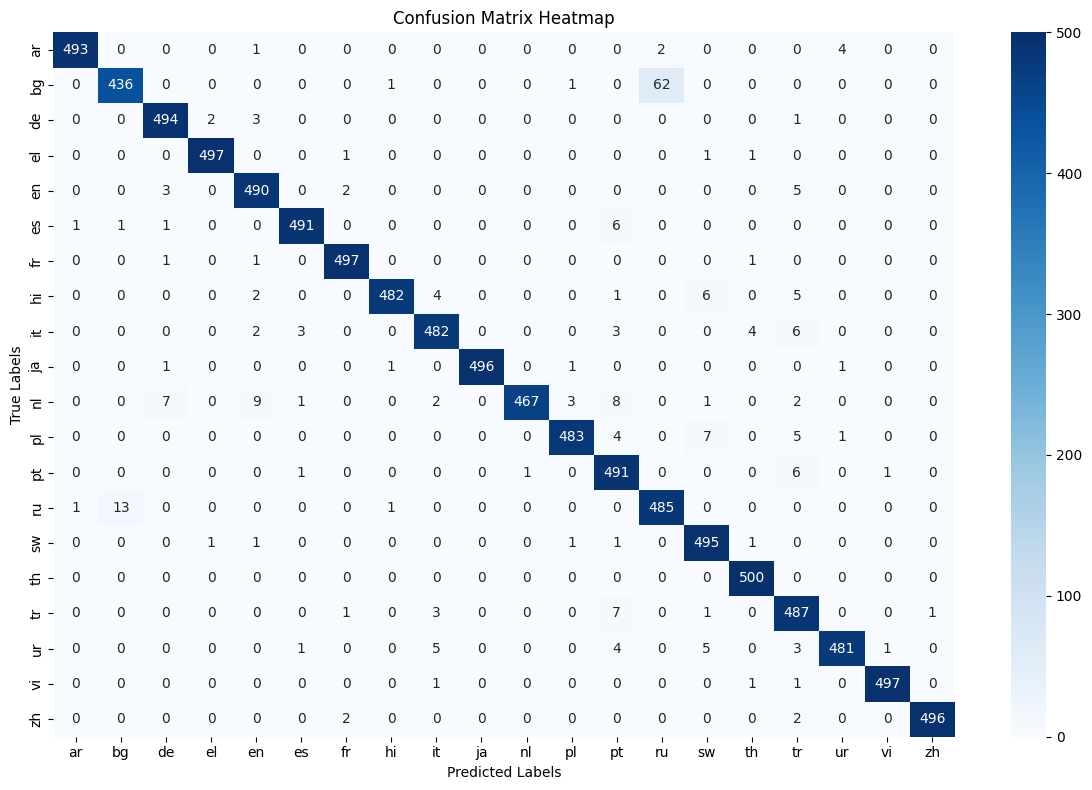

In [ ]:
# cm with heatmap
cm = confusion_matrix(dftest['labels'], dftest['prediction'])
confusion_df = pd.DataFrame(cm,
                            index=label_encoder.classes_,
                            columns=label_encoder.classes_)

plt.figure(figsize=(12, 8))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=True)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

In [ ]:
def detect_language(text):

    preprocessed_text = preprocess_text(text, 'unknown')
    vectorized_text = vectorize_layer([preprocessed_text]).numpy()
    prediction = model.predict(vectorized_text)
    predicted_label = label_encoder.inverse_transform(prediction.argmax(axis=1))[0]

    return predicted_label

def interactive_language_detection():
    print("Welcome to the Language Detection Tool!")
    print("Type 'quit' to exit.")

    while True:
        user_input = input("\nEnter text to detect language: ")

        if user_input.lower() == 'quit': #type quit to end loop
            print("Thank you for using the Language Detection Tool. Goodbye!")
            break

        detected_language = detect_language(user_input)

        print(f"Detected language: {detected_language}")


interactive_language_detection()

Welcome to the Language Detection Tool!
Type 'quit' to exit.

Enter text to detect language: I fly past the smaller shops, past the men drinking wine on the benches, past the old men playing dominoes, past the restaurants and the Arabs selling clothes and rugs and shoes, past the twins my age, Ahok and Awach Ugieth, two very kind and hardworking girls carrying bundles of kindling on their heads, Hello, Hello, we say, and finally I step into the darkness of my father’s stores, completely out of breath
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Detected language: en

Enter text to detect language: Volo oltre i negozi più piccoli, oltre gli uomini che bevono vino sulle panchine, oltre i vecchi che giocano a domino, oltre i ristoranti e gli arabi che vendono vestiti, tappeti e scarpe, oltre i gemelli della mia età, Ahok e Awach Ugieth, due persone molto gentili e ragazze laboriose con fascine di legna in testa, Ciao, Ciao, diciamo, e finalmente entro nel buio dei magazzini di mio padre, complet